# Data set exploration

- Binary classification problem
In this project, I'm gonna use the Diabetes dataset originally comes from the UCI machine learning repository. The data consists of over 100000 hospital admissions from patients with diabetes from 130 US hospitals between 1999-2008

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

In [2]:
df = pd.read_csv('diabetic_data.csv')
print('Number of samples: ', len(df))
df.info()

Number of samples:  101766
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101766 entries, 0 to 101765
Data columns (total 50 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   encounter_id              101766 non-null  int64 
 1   patient_nbr               101766 non-null  int64 
 2   race                      101766 non-null  object
 3   gender                    101766 non-null  object
 4   age                       101766 non-null  object
 5   weight                    101766 non-null  object
 6   admission_type_id         101766 non-null  int64 
 7   discharge_disposition_id  101766 non-null  int64 
 8   admission_source_id       101766 non-null  int64 
 9   time_in_hospital          101766 non-null  int64 
 10  payer_code                101766 non-null  object
 11  medical_specialty         101766 non-null  object
 12  num_lab_procedures        101766 non-null  int64 
 13  num_procedures            101766

Overall, the columns are in various types: identification columns, numerical columns, categorical (free-text) columns.

In [3]:
df.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,...,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


- There is some missing data that are represented with ?. We will deal with this in the feature engineering section
- The most important column here is readmitted, which tell us if a patient was hospitalized within 30 days, greater than 30 days or not readmitted

In [4]:
#count the number of rows for each type
df.groupby('readmitted').size()

readmitted
<30    11357
>30    35545
NO     54864
dtype: int64

Another column that is important is discharge_disposition_id which tells us where the patient went after hospitalization.

In [5]:
df.groupby('discharge_disposition_id').size()

discharge_disposition_id
1     60234
2      2128
3     13954
4       815
5      1184
6     12902
7       623
8       108
9        21
10        6
11     1642
12        3
13      399
14      372
15       63
16       11
17       14
18     3691
19        8
20        2
22     1993
23      412
24       48
25      989
27        5
28      139
dtype: int64

By looking at IDs_mapping.csv, we can see that 11, 13, 14, 19, 20, 21 are related to death or hospice -> remove

In [6]:
df = df.loc[~df.discharge_disposition_id.isin([11,13,14,19,20,21])]

This step we are preparing the output for our binary classification problem. We will try to predict if a patient is likely to be re-admitted within 30 days of discharge

In [7]:
df['OUTPUT_LABEL'] = (df.readmitted == '<30').astype('int')


Define a function to calculate the prevalence of population that is readmitted with 30 days

In [8]:
def calcPrevalence(y_actual):
    return (sum(y_actual)/len(y_actual))

print('Prevalence: %.3f'%calcPrevalence(df['OUTPUT_LABEL'].values))

Prevalence: 0.114


In a similar fashion with other medical data, this represented an imbalanced classification problem so we will address that below

In [9]:
print('Number of columns:', len(df.columns))

Number of columns: 51


In [10]:
df[list(df.columns)[:10]].head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1


In [11]:
df[list(df.columns)[20:30]].head()

,diag_3,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide
0,?,1,None,None,No,No,No,No,No,No
1,255,9,None,None,No,No,No,No,No,No
2,V27,6,None,None,No,No,No,No,No,No
3,403,7,None,None,No,No,No,No,No,No
4,250,5,None,None,No,No,No,No,No,No


In [12]:
df[list(df.columns)[40:]].head()

,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted,OUTPUT_LABEL
0,No,No,No,No,No,No,No,No,No,NO,0
1,No,Up,No,No,No,No,No,Ch,Yes,>30,0
2,No,No,No,No,No,No,No,No,Yes,NO,0
3,No,Up,No,No,No,No,No,Ch,Yes,NO,0
4,No,Steady,No,No,No,No,No,Ch,Yes,NO,0


From this, we see that there are a lot of categorical (non-numeric) variables. Note that the variables with _id are also categorical and you can see what the ids refer to with the IDs_mapping.csv. Let's take a look at the unique values for each column.

In [13]:
for c in list(df.columns):
    n = df[c].unique()
    if len(n) < 30:
        print(c)
        print(n)
    else:
        print(c + ': ' + str(len(n))+ ' unique values')

encounter_id: 99343 unique values
patient_nbr: 69990 unique values
race
['Caucasian' 'AfricanAmerican' '?' 'Other' 'Asian' 'Hispanic']
gender
['Female' 'Male' 'Unknown/Invalid']
age
['[0-10)' '[10-20)' '[20-30)' '[30-40)' '[40-50)' '[50-60)' '[60-70)'
 '[70-80)' '[80-90)' '[90-100)']
weight
['?' '[75-100)' '[50-75)' '[0-25)' '[100-125)' '[25-50)' '[125-150)'
 '[175-200)' '[150-175)' '>200']
admission_type_id
[6 1 2 3 4 5 8 7]
discharge_disposition_id
[25  1  3  6  2  5  7 10  4 18  8 12 16 17 22 23  9 15 24 28 27]
admission_source_id
[ 1  7  2  4  5 20  6  3 17  8  9 14 10 22 11 25 13]
time_in_hospital
[ 1  3  2  4  5 13 12  9  7 10  6 11  8 14]
payer_code
['?' 'MC' 'MD' 'HM' 'UN' 'BC' 'SP' 'CP' 'SI' 'DM' 'CM' 'CH' 'PO' 'WC' 'OT'
 'OG' 'MP' 'FR']
medical_specialty: 73 unique values
num_lab_procedures: 118 unique values
num_procedures
[0 5 1 6 2 3 4]
num_medications: 75 unique values
number_outpatient: 39 unique values
number_emergency: 33 unique values
number_inpatient
[ 0  1  2  3  6 


From analysis of the columns, we can see there are a mix of categorical (non-numeric) and numerical data. A few things to point out,

- encounter_id and patient_nbr: these are just identifiers and not useful variables
- age and weight: are categorical in this data set
- admission_type_id,discharge_disposition_id,admission_source_id: are numerical here, but are IDs (see IDs_mapping). They should be considered categorical. 
- examide and citoglipton only have 1 value, so we will not use these variables
- diag1, diag2, diag3 - are categorical and have a lot of values. We will not use these as part of this project, but you could group these ICD codes to reduce the dimension. We will use number_diagnoses to capture some of this information. 
- medical_speciality - has many categorical variables, so we should consider this when making features. 



# Feature engineering


In this section, we will create features for our predictive model.

In [14]:
# replace ? with nan
df = df.replace('?',np.nan)


# Numerical Features

The easiest type of features to use is numerical features. These features do not need any modification. The columns that are numerical that we will use are shown below


In [15]:
cols_num = ['time_in_hospital','num_lab_procedures', 'num_procedures', 'num_medications',
       'number_outpatient', 'number_emergency', 'number_inpatient','number_diagnoses']

df[cols_num].isnull().sum()

time_in_hospital      0
num_lab_procedures    0
num_procedures        0
num_medications       0
number_outpatient     0
number_emergency      0
number_inpatient      0
number_diagnoses      0
dtype: int64

# Categorical Features
Definition: non-numeric data such as race and gender. To turn this non-numerical data into variables, the simplest thing is to use a technique called one-hot encoding, which will be explained below

In [16]:
cols_cat = ['race', 'gender', 
       'max_glu_serum', 'A1Cresult',
       'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide',
       'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
       'tolazamide', 'insulin',
       'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'change', 'diabetesMed','payer_code']
df[cols_cat].isnull().sum()

race                         2234
gender                          0
max_glu_serum                   0
A1Cresult                       0
metformin                       0
repaglinide                     0
nateglinide                     0
chlorpropamide                  0
glimepiride                     0
acetohexamide                   0
glipizide                       0
glyburide                       0
tolbutamide                     0
pioglitazone                    0
rosiglitazone                   0
acarbose                        0
miglitol                        0
troglitazone                    0
tolazamide                      0
insulin                         0
glyburide-metformin             0
glipizide-metformin             0
glimepiride-pioglitazone        0
metformin-rosiglitazone         0
metformin-pioglitazone          0
change                          0
diabetesMed                     0
payer_code                  39398
dtype: int64

In [17]:
df['race'] = df['race'].fillna('UNK')
df['payer_code'] = df['payer_code'].fillna('UNK')
df['medical_specialty'] = df['medical_specialty'].fillna('UNK')

Let's investigate medical specialty before we begin.

In [18]:
print('Number medical specialty:', df.medical_specialty.nunique())
df.groupby('medical_specialty').size().sort_values(ascending = False)

Number medical specialty: 73


medical_specialty
UNK                                 48616
InternalMedicine                    14237
Emergency/Trauma                     7419
Family/GeneralPractice               7252
Cardiology                           5279
                                    ...  
Surgery-PlasticwithinHeadandNeck        1
Dermatology                             1
Proctology                              1
Psychiatry-Addictive                    1
Speech                                  1
Length: 73, dtype: int64

Most of them are unknown and the count drops off pretty quickly. Adding 73 new variables is a waste. As an alternative, we can create a new variable that only has 11 options

In [19]:
top10 = ['UNK','InternalMedicine','Emergency/Trauma',\
          'Family/GeneralPractice', 'Cardiology','Surgery-General' ,\
          'Nephrology','Orthopedics',\
          'Orthopedics-Reconstructive','Radiologist']

# make a new column with duplicated data
df['med_spec'] = df['medical_specialty'].copy()

# replace all specialties not in top 10 with 'Other' category
df.loc[~df.med_spec.isin(top10), 'med_spec'] = 'Other'
df.groupby('med_spec').size()

med_spec
Cardiology                     5279
Emergency/Trauma               7419
Family/GeneralPractice         7252
InternalMedicine              14237
Nephrology                     1539
Orthopedics                    1392
Orthopedics-Reconstructive     1230
Other                          8199
Radiologist                    1121
Surgery-General                3059
UNK                           48616
dtype: int64

function to convert categorical features to numbers is get_dummies in pandas, but it does not work on numerical data. To trick get_dummies, we can convert the numerical data into strings

In [20]:
cols_cat_num = ['admission_type_id', 'discharge_disposition_id', 'admission_source_id']
df[cols_cat_num] = df[cols_cat_num].astype('str')

In [21]:
df_cat = pd.get_dummies(df[cols_cat + cols_cat_num + ['med_spec']], drop_first=True)
df_cat.head()

,race_Asian,race_Caucasian,race_Hispanic,race_Other,race_UNK,gender_Male,gender_Unknown/Invalid,max_glu_serum_>300,max_glu_serum_None,max_glu_serum_Norm,...,med_spec_Emergency/Trauma,med_spec_Family/GeneralPractice,med_spec_InternalMedicine,med_spec_Nephrology,med_spec_Orthopedics,med_spec_Orthopedics-Reconstructive,med_spec_Other,med_spec_Radiologist,med_spec_Surgery-General,med_spec_UNK
0,0,1,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0
1,0,1,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
2,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
3,0,1,0,0,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
4,0,1,0,0,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1


Use concat function to add the one-hot encoding to the dataframe

In [22]:
df = pd.concat([df,df_cat], axis = 1)

Save the column names of the categorical data.

In [23]:
cols_all_cat = list(df_cat.columns)

# Extra feature

In [24]:
df[['age', 'weight']].head()

,age,weight
0,[0-10),NaN
1,[10-20),NaN
2,[20-30),NaN
3,[30-40),NaN
4,[40-50),NaN


In [25]:
df.groupby('age').size()

age
[0-10)        160
[10-20)       690
[20-30)      1649
[30-40)      3764
[40-50)      9607
[50-60)     17060
[60-70)     22059
[70-80)     25331
[80-90)     16434
[90-100)     2589
dtype: int64

Let's map these to 0-9 for the numerical data.

In [26]:
age_id = {'[0-10)':0, 
          '[10-20)':10, 
          '[20-30)':20, 
          '[30-40)':30, 
          '[40-50)':40, 
          '[50-60)':50,
          '[60-70)':60, 
          '[70-80)':70, 
          '[80-90)':80, 
          '[90-100)':90}
df['age_group'] = df.age.replace(age_id)
df.weight.notnull().sum()

3125

In [27]:
df['has_weight'] = df.weight.notnull().astype('int')

#Keep track of extra column
cols_extra = ['age_group','has_weight']

# Engineering Features Summary:

In [28]:
print('Total number of features:', len(cols_num + cols_all_cat + cols_extra))
print('Numerical Features:',len(cols_num))
print('Categorical Features:',len(cols_all_cat))
print('Extra features:',len(cols_extra))

Total number of features: 143
Numerical Features: 8
Categorical Features: 133
Extra features: 2


Make new dataframe that only has the columns of interest

In [29]:
colForUse = cols_num + cols_all_cat + cols_extra
df_data = df[colForUse + ['OUTPUT_LABEL']]

# Building Training/Validation/Test samples

In [30]:
# shuffle the samples
df_data = df_data.sample(n = len(df_data), random_state = 42)
df_data = df_data.reset_index(drop = True)

In [31]:
# Save 30% of the data as validation and test data 
df_valid_test=df_data.sample(frac=0.30,random_state=42)
print('Split size: %.3f'%(len(df_valid_test)/len(df_data)))

Split size: 0.300


In [32]:
df_test = df_valid_test.sample(frac = 0.5, random_state = 42)
df_valid = df_valid_test.drop(df_test.index)
df_train_all=df_data.drop(df_valid_test.index)

At this point, let's check what percent of our groups are hospitalized within 30 days. This is known as prevalence. Ideally, all three groups would have similar prevalance.


In [33]:


print('Test prevalence(n = %d):%.3f'%(len(df_test),calcPrevalence(df_test.OUTPUT_LABEL.values)))
print('Valid prevalence(n = %d):%.3f'%(len(df_valid),calcPrevalence(df_valid.OUTPUT_LABEL.values)))
print('Train all prevalence(n = %d):%.3f'%(len(df_train_all), calcPrevalence(df_train_all.OUTPUT_LABEL.values)))

Test prevalence(n = 14902):0.117
Valid prevalence(n = 14901):0.113
Train all prevalence(n = 69540):0.113


# Tackle imbalanced data problem

There are 3 strategies that are typically utilized:
- sub-sample the more dominant class: use a random subset of negatives
- over-sample the imbalanced class: use the same positive samples multiple times
- create synthetic positive data

Since we have few thousand postive cases, let's use the sub-sample approach. Here, we will create a balanced training data set that ha 50% positive and 50% negative

In [34]:
# split the training data into positive and negative
rows_pos = df_train_all.OUTPUT_LABEL == 1
df_train_pos = df_train_all.loc[rows_pos]
df_train_neg = df_train_all.loc[~rows_pos]

#merge the balanced data
df_train = pd.concat([df_train_pos, df_train_neg.sample(n = len(df_train_pos), random_state = 42)], axis = 0)

#shuffle the order of training samples
df_train = df_train.sample(n = len(df_train), random_state=42).reset_index(drop = True)

print('Train balanced prevalence (n = %d): %.3f'%(len(df_train), calcPrevalence(df_train.OUTPUT_LABEL.values)))

Train balanced prevalence (n = 15766): 0.500


In [35]:
print('Save everything to csv:')
df_train_all.to_csv('all.csv', index = False)
df_train.to_csv('train.csv', index = False)
df_valid.to_csv('valid.csv', index = False)
df_test.to_csv('test.csv', index = False)
print('Done!')

Save everything to csv:
Done!


Most machine learning packages like to use an input matrix X and output vector y, so let's create those:

In [36]:
X_train = df_train[colForUse].values
X_train_all = df_train_all[colForUse].values
X_valid = df_valid[colForUse].values

y_train = df_train['OUTPUT_LABEL'].values
y_valid = df_valid['OUTPUT_LABEL'].values

print('All training data has shape:', X_train_all.shape)
print('Selected data to train shapes: ', X_train.shape, y_train.shape)
print('Validation shapes:', X_valid.shape, y_valid.shape)

All training data has shape: (69540, 143)
Selected data to train shapes:  (15766, 143) (15766,)
Validation shapes: (14901, 143) (14901,)


**Scale the data**

Here we will use scikit learn's Standard Scaler which removes the mean and scales to unit variance. 

In [37]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train_all)

StandardScaler()

We will need this scaler for the test data, so let's save it using a package called pickle.

In [38]:
import pickle
scalerfile = 'scaler.sav'
pickle.dump(scaler, open(scalerfile, 'wb'))

#load it back
scaler = pickle.load(open(scalerfile, 'rb'))

In [39]:
X_train_tf = scaler.transform(X_train)
X_valid_tf = scaler.transform(X_valid)

**# Model selection**

In this section, we train a few machine learning models and use a few techniques for optimizing them. We will then select the best model based on performance on the validation set.

In [40]:
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score

def calcSpecificity(y_actual, y_predict, thresh):
    return sum((y_predict < thresh) & (y_actual == 0)) /sum(y_actual ==0)

def print_report(y_actual, y_pred, thresh):
    
    auc = roc_auc_score(y_actual, y_pred)
    accuracy = accuracy_score(y_actual, (y_pred > thresh))
    recall = recall_score(y_actual, (y_pred > thresh))
    precision = precision_score(y_actual, (y_pred > thresh))
    specificity = calcSpecificity(y_actual, y_pred, thresh)
    print('AUC:%.3f'%auc)
    print('accuracy:%.3f'%accuracy)
    print('recall:%.3f'%recall)
    print('precision:%.3f'%precision)
    print('specificity:%.3f'%specificity)
    print('prevalence:%.3f'%calcPrevalence(y_actual))
    print(' ')
    return auc, accuracy, recall, precision, specificity

Since we balanced our training data, let's set our threshold at 0.5 to label a predicted sample as positive.

In [41]:
thresh = 0.5

# Model Selection: baseline models:



In this section, we will compare the performance of 7 machine learning models using default hyperparameters.

In [42]:
# k-nearest neighbors
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors = 100)
knn.fit(X_train_tf, y_train)

KNeighborsClassifier(n_neighbors=100)

In [43]:
y_train_preds = knn.predict_proba(X_train_tf)[:,1]
y_valid_preds = knn.predict_proba(X_valid_tf)[:,1]

print('K Nearest Neighbor:')
print('Training:')
knn_train_auc, knn_train_accuracy, knn_train_recall, \
    knn_train_precision, knn_train_specificity = print_report(y_train,y_train_preds, thresh)
print('Validation:')
knn_valid_auc, knn_valid_accuracy, knn_valid_recall, \
    knn_valid_precision, knn_valid_specificity = print_report(y_valid,y_valid_preds, thresh)

K Nearest Neighbor:
Training:
AUC:0.650
accuracy:0.603
recall:0.491
precision:0.633
specificity:0.673
prevalence:0.500
 
Validation:
AUC:0.621
accuracy:0.670
recall:0.469
precision:0.165
specificity:0.655
prevalence:0.113
 


# Logistic regression

In [44]:
# logistic regression
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(random_state = 42)
lr.fit(X_train_tf, y_train)

LogisticRegression(random_state=42)

In [45]:
y_train_preds = lr.predict_proba(X_train_tf)[:,1]
y_valid_preds = lr.predict_proba(X_valid_tf)[:,1]

print('Logistic Regression')
print('Training:')
lr_train_auc, lr_train_accuracy, lr_train_recall, \
    lr_train_precision, lr_train_specificity = print_report(y_train,y_train_preds, thresh)
print('Validation:')
lr_valid_auc, lr_valid_accuracy, lr_valid_recall, \
    lr_valid_precision, lr_valid_specificity = print_report(y_valid,y_valid_preds, thresh)

Logistic Regression
Training:
AUC:0.678
accuracy:0.628
recall:0.558
precision:0.649
specificity:0.698
prevalence:0.500
 
Validation:
AUC:0.661
accuracy:0.662
recall:0.558
precision:0.180
specificity:0.675
prevalence:0.113
 


# Stochastic Gradient Descent

When you have a lot of data logistic regression may take a long time to compute. There is an alternative approach called stochastic gradient descent that works similarly to logistic regression but doesn't use all the data at each iteration.

In [46]:
from sklearn.linear_model import SGDClassifier
sgdc = SGDClassifier(loss = 'log',alpha = 0.1,random_state = 42)
sgdc.fit(X_train_tf, y_train)

SGDClassifier(alpha=0.1, loss='log', random_state=42)

In [47]:
y_train_preds = sgdc.predict_proba(X_train_tf)[:,1]
y_valid_preds = sgdc.predict_proba(X_valid_tf)[:,1]

print('Stochastic Gradient Descend')
print('Training:')
sgdc_train_auc, sgdc_train_accuracy, sgdc_train_recall, sgdc_train_precision, sgdc_train_specificity =print_report(y_train,y_train_preds, thresh)
print('Validation:')
sgdc_valid_auc, sgdc_valid_accuracy, sgdc_valid_recall, sgdc_valid_precision, sgdc_valid_specificity = print_report(y_valid,y_valid_preds, thresh)

Stochastic Gradient Descend
Training:
AUC:0.676
accuracy:0.624
recall:0.550
precision:0.645
specificity:0.698
prevalence:0.500
 
Validation:
AUC:0.661
accuracy:0.664
recall:0.553
precision:0.180
specificity:0.678
prevalence:0.113
 


# Naive Bayes

In [48]:
from sklearn.naive_bayes import GaussianNB

nb = GaussianNB()
nb.fit(X_train_tf, y_train)

GaussianNB()

In [49]:
y_train_preds = nb.predict_proba(X_train_tf)[:,1]
y_valid_preds = nb.predict_proba(X_valid_tf)[:,1]

print('Naive Bayes')
print('Training:')
nb_train_auc, nb_train_accuracy, nb_train_recall, nb_train_precision, nb_train_specificity =print_report(y_train,y_train_preds, thresh)
print('Validation:')
nb_valid_auc, nb_valid_accuracy, nb_valid_recall, nb_valid_precision, nb_valid_specificity = print_report(y_valid,y_valid_preds, thresh)

Naive Bayes
Training:
AUC:0.508
accuracy:0.506
recall:0.989
precision:0.503
specificity:0.022
prevalence:0.500
 
Validation:
AUC:0.505
accuracy:0.129
recall:0.988
precision:0.114
specificity:0.020
prevalence:0.113
 


# Decision Tree Classifier

In [50]:
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier(max_depth = 10, random_state = 42)
tree.fit(X_train_tf, y_train)

DecisionTreeClassifier(max_depth=10, random_state=42)

In [51]:
y_train_preds = tree.predict_proba(X_train_tf)[:,1]
y_valid_preds = tree.predict_proba(X_valid_tf)[:,1]

print('Decision Tree')
print('Training:')
tree_train_auc, tree_train_accuracy, tree_train_recall, tree_train_precision, tree_train_specificity =print_report(y_train,y_train_preds, thresh)
print('Validation:')
tree_valid_auc, tree_valid_accuracy, tree_valid_recall, tree_valid_precision, tree_valid_specificity = print_report(y_valid,y_valid_preds, thresh)

Decision Tree
Training:
AUC:0.736
accuracy:0.672
recall:0.629
precision:0.688
specificity:0.713
prevalence:0.500
 
Validation:
AUC:0.623
accuracy:0.636
recall:0.570
precision:0.170
specificity:0.642
prevalence:0.113
 


# Random Forest

In [52]:
from sklearn.ensemble import RandomForestClassifier
rf=RandomForestClassifier(max_depth = 6, random_state = 42)
rf.fit(X_train_tf, y_train)

RandomForestClassifier(max_depth=6, random_state=42)

In [53]:
y_train_preds = rf.predict_proba(X_train_tf)[:,1]
y_valid_preds = rf.predict_proba(X_valid_tf)[:,1]

print('Random Forest')
print('Training:')
rf_train_auc, rf_train_accuracy, rf_train_recall, rf_train_precision, rf_train_specificity =print_report(y_train,y_train_preds, thresh)
print('Validation:')
rf_valid_auc, rf_valid_accuracy, rf_valid_recall, rf_valid_precision, rf_valid_specificity = print_report(y_valid,y_valid_preds, thresh)

Random Forest
Training:
AUC:0.696
accuracy:0.643
recall:0.612
precision:0.652
specificity:0.673
prevalence:0.500
 
Validation:
AUC:0.657
accuracy:0.629
recall:0.604
precision:0.173
specificity:0.633
prevalence:0.113
 


# Gradient Boosting Classifier

In [54]:
from sklearn.ensemble import GradientBoostingClassifier
gbc =GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,
     max_depth=3, random_state=42)
gbc.fit(X_train_tf, y_train)

GradientBoostingClassifier(learning_rate=1.0, random_state=42)

In [55]:
y_train_preds = gbc.predict_proba(X_train_tf)[:,1]
y_valid_preds = gbc.predict_proba(X_valid_tf)[:,1]

print('Gradient Boosting Classifier')
print('Training:')
gbc_train_auc, gbc_train_accuracy, gbc_train_recall, gbc_train_precision, gbc_train_specificity = print_report(y_train,y_train_preds, thresh)
print('Validation:')
gbc_valid_auc, gbc_valid_accuracy, gbc_valid_recall, gbc_valid_precision, gbc_valid_specificity = print_report(y_valid,y_valid_preds, thresh)

Gradient Boosting Classifier
Training:
AUC:0.772
accuracy:0.695
recall:0.668
precision:0.706
specificity:0.722
prevalence:0.500
 
Validation:
AUC:0.638
accuracy:0.620
recall:0.574
precision:0.164
specificity:0.626
prevalence:0.113
 


# Analyze results baseline models

Let's make a dataframe with these results and plot the outcomes using a package called seaborn. In this project, we will utilize the Area under the ROC curve (AUC) to evaluate the best model. This is a good data science performance metric for picking the best model since it captures the trade off between the true positive and false positive and does not require selecting a threshold.

In [56]:
df_results = pd.DataFrame({'classifier':['KNN','KNN','LR','LR','SGD','SGD','NB','NB','DT','DT','RF','RF','GB','GB'],
                           'data_set':['train','valid']*7,
                          'auc':[knn_train_auc, knn_valid_auc,lr_train_auc,lr_valid_auc,sgdc_train_auc,sgdc_valid_auc,nb_train_auc,nb_valid_auc,tree_train_auc,tree_valid_auc,rf_train_auc,rf_valid_auc,gbc_valid_auc,gbc_valid_auc,],
                          'accuracy':[knn_train_accuracy, knn_valid_accuracy,lr_train_accuracy,lr_valid_accuracy,sgdc_train_accuracy,sgdc_valid_accuracy,nb_train_accuracy,nb_valid_accuracy,tree_train_accuracy,tree_valid_accuracy,rf_train_accuracy,rf_valid_accuracy,gbc_valid_accuracy,gbc_valid_accuracy,],
                          'recall':[knn_train_recall, knn_valid_recall,lr_train_recall,lr_valid_recall,sgdc_train_recall,sgdc_valid_recall,nb_train_recall,nb_valid_recall,tree_train_recall,tree_valid_recall,rf_train_recall,rf_valid_recall,gbc_valid_recall,gbc_valid_recall,],
                          'precision':[knn_train_precision, knn_valid_precision,lr_train_precision,lr_valid_precision,sgdc_train_precision,sgdc_valid_precision,nb_train_precision,nb_valid_precision,tree_train_precision,tree_valid_precision,rf_train_precision,rf_valid_precision,gbc_valid_auc,gbc_valid_precision,],
                          'specificity':[knn_train_specificity, knn_valid_specificity,lr_train_specificity,lr_valid_specificity,sgdc_train_specificity,sgdc_valid_specificity,nb_train_specificity,nb_valid_specificity,tree_train_specificity,tree_valid_specificity,rf_train_specificity,rf_valid_specificity,gbc_valid_specificity,gbc_valid_specificity,]})

In [57]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="darkgrid")

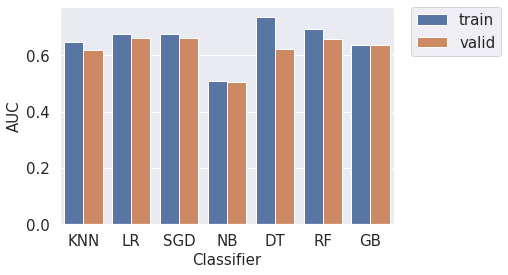

In [58]:
ax = sns.barplot(x="classifier", y="auc", hue="data_set", data=df_results)
ax.set_xlabel('Classifier',fontsize = 15)
ax.set_ylabel('AUC', fontsize = 15)
ax.tick_params(labelsize=15)

# Put the legend out of the figure
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize = 15)
plt.show()

# Model selection: Learning curve

In [59]:
import numpy as np
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("AUC")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring = 'roc_auc')
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="b")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="b",
             label="Cross-validation score")
    plt.legend(loc="best")
    return plt


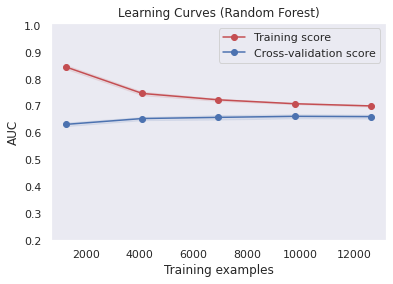

In [60]:
title = "Learning Curves (Random Forest)"
# Cross validation with 5 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
estimator = RandomForestClassifier(max_depth = 6, random_state = 42)
plot_learning_curve(estimator, title, X_train_tf, y_train, ylim=(0.2, 1.01), cv=cv, n_jobs=4)

plt.show()

In the case of random forest, we can see the training and validation scores are similar but they both have low scores. This is called high bias and is a sign of underfitting.

# Model Selection: Feature Importance

One path for improving your models to understand what features are important to your models. This can usually only be investigated for simpler models such as Logistic Regression or Random Forests

**Feature Importance: Logistic regression**
Logistic regression is a very interpretable model because the coefficient for each variable shows how important that variable is for the prediction. Note that you need to have normalized the data so the coefficients are comparable between variables. We can extract the coefficients using coef_ and store in a new dataframe (sorted by importance)

In [61]:
feature_importances =  pd.DataFrame(lr.coef_[0], index = colForUse, columns = ['importance']).sort_values('importance', ascending = False)
feature_importances.head()

,importance
number_inpatient,0.356971
rosiglitazone_No,0.284600
rosiglitazone_Steady,0.238721
discharge_disposition_id_22,0.202499
repaglinide_No,0.169205


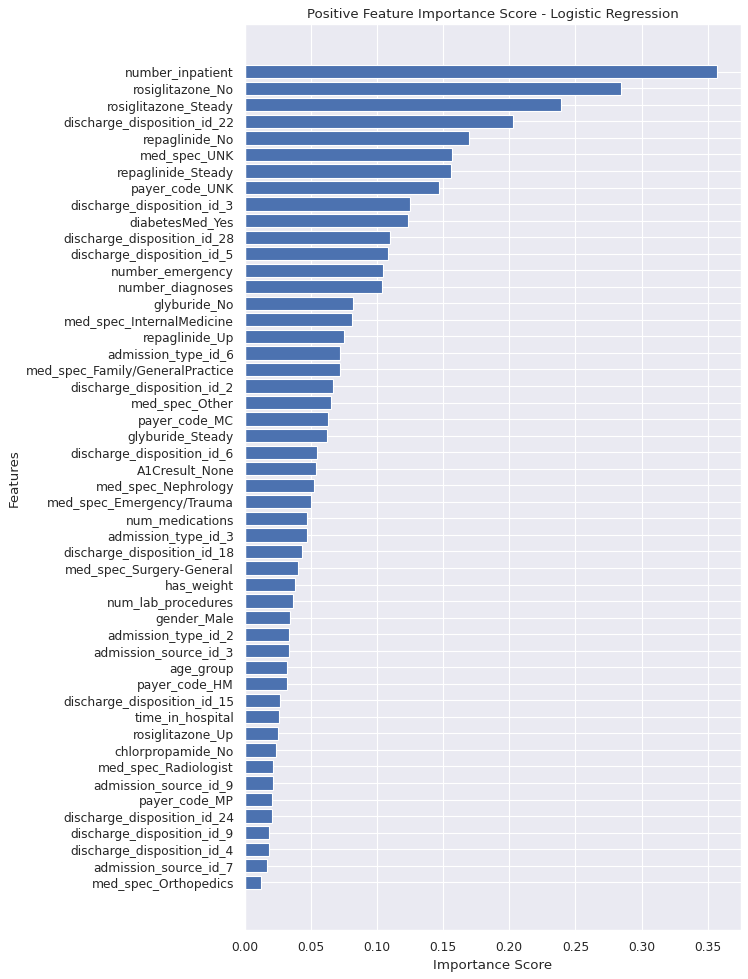

In [63]:
num = 50
ylocs = np.arange(num)
# get the feature importance for top num and sort in reverse order
values_to_plot = feature_importances.iloc[:num].values.ravel()[::-1]
feature_labels = list(feature_importances.iloc[:num].index)[::-1]

plt.figure(num=None, figsize=(8, 15), dpi=80, facecolor='w', edgecolor='k');
plt.barh(ylocs, values_to_plot, align = 'center')
plt.ylabel('Features')
plt.xlabel('Importance Score')
plt.title('Positive Feature Importance Score - Logistic Regression')
plt.yticks(ylocs, feature_labels)
plt.show()

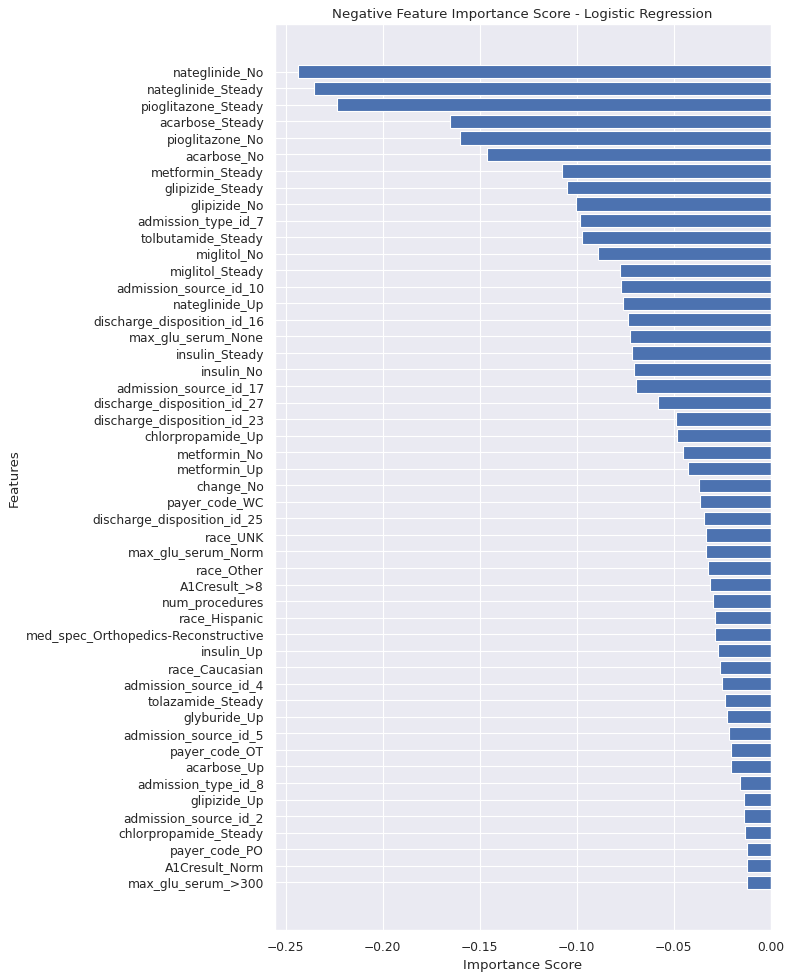

In [64]:
values_to_plot = feature_importances.iloc[-num:].values.ravel()
feature_labels = list(feature_importances.iloc[-num:].index)

plt.figure(num=None, figsize=(8, 15), dpi=80, facecolor='w', edgecolor='k');
plt.barh(ylocs, values_to_plot, align = 'center')
plt.ylabel('Features')
plt.xlabel('Importance Score')
plt.title('Negative Feature Importance Score - Logistic Regression')
plt.yticks(ylocs, feature_labels)
plt.show()


**Feature Importance: random forest**

We can also investigate feature importance for random forest models. In this case, the feature importance shows how often a particular feature was used to split the data. In this case, we don't know if a particular feature is correlated with the positive class or negative class, but rather it is just importance for making a decision.

In [65]:
feature_importances = pd.DataFrame(rf.feature_importances_, index = colForUse, columns=['importance']).sort_values('importance',ascending=False)
feature_importances.head()

,importance
number_inpatient,0.280585
number_emergency,0.076902
discharge_disposition_id_22,0.070238
num_medications,0.060644
number_diagnoses,0.049529


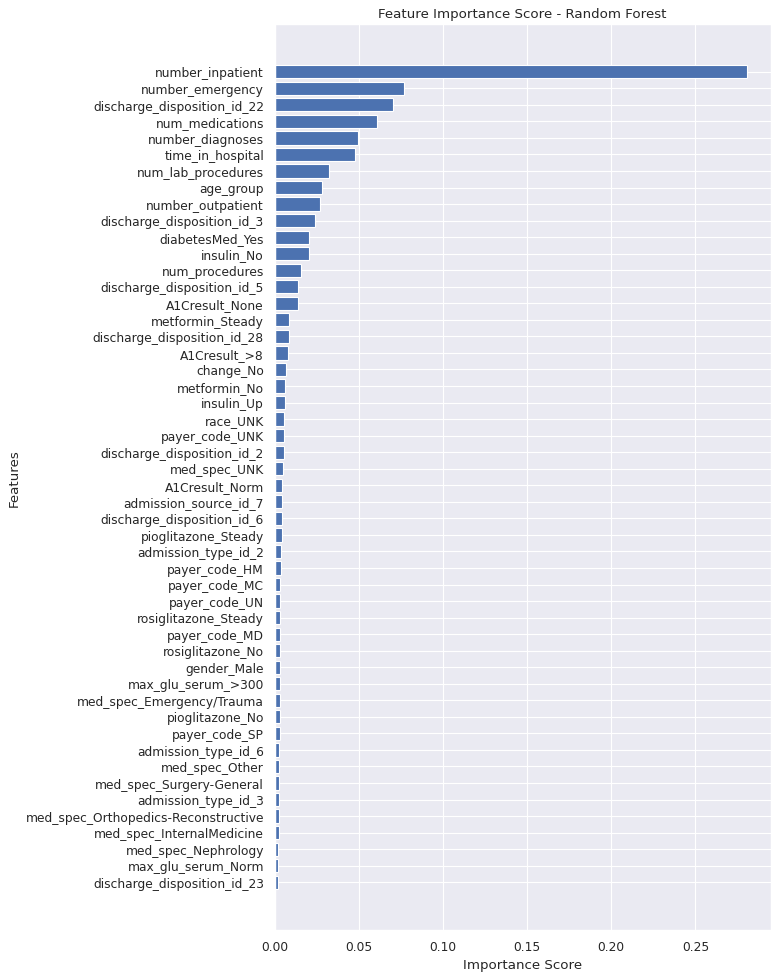

In [66]:
num = 50
ylocs = np.arange(num)
# get the feature importance for top num and sort in reverse order
values_to_plot = feature_importances.iloc[:num].values.ravel()[::-1]
feature_labels = list(feature_importances.iloc[:num].index)[::-1]

plt.figure(num=None, figsize=(8, 15), dpi=80, facecolor='w', edgecolor='k');
plt.barh(ylocs, values_to_plot, align = 'center')
plt.ylabel('Features')
plt.xlabel('Importance Score')
plt.title('Feature Importance Score - Random Forest')
plt.yticks(ylocs, feature_labels)
plt.show()